# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBINS = 1000
SIGMA = 0.01

In [3]:
# A toy model with a diffuse and point source component

def model(z, sigma = SIGMA, w = 0.4):
    x = z + np.random.randn(2)*sigma + (np.random.rand(2)-0.5)*w
    return x

In [4]:
z0 = np.array([0.5, 0.5])
x0 = np.array([0.5, 0.5])

In [5]:
ds = swyft.DataStoreZarr("/home/ubuntu/volume1/zzzz1")
ds.init(zdim = 2, xdim = (2,))

Loading datastore: /home/ubuntu/volume1/zzzz1


In [7]:
# Instantiate network
sw = swyft.LFI(x0, model, zdim = 2, device = DEVICE, head = None, datastore = ds)

In [8]:
sw.init_train_data(nsamples = 1000)

Constrained posterior area: 1.0
No new simulator runs required.


In [9]:
if sw.requires_sim():
    for i in ds.require_sim():
        z = ds.z[i]
        x = model(z)
        ds.add_sim(i, x)

In [10]:
sw.init_net1d()

In [11]:
sw.train1d(max_epochs = 1, nbatch = 32)

Start training
LR iteration 0
Total epochs: 1
Validation losses: [5.313404738903046]
LR iteration 1
Total epochs: 1
Validation losses: [5.235398292541504]
LR iteration 2
Total epochs: 1
Validation losses: [5.2269273698329926]


In [12]:
sw.eval_post1d()

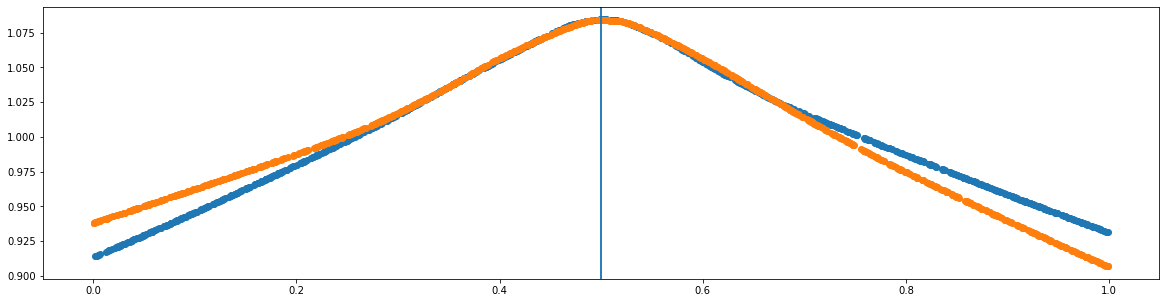

In [13]:
plt.figure(figsize=(20, 5))
for i in range(2):
    z, p = sw.posterior(i)
    plt.axvline(z0[i])
    plt.scatter(z, p)

In [14]:
sw2 = swyft.LFI(x0, model, zdim = 2, device = DEVICE, head = None, datastore = ds, parent = sw)
sw2.init_train_data(nsamples = 1000)

Constrained posterior area: 1.0
No new simulator runs required.


In [17]:
if sw2.requires_sim():
    for i in ds.require_sim():
        z = ds.z[i]
        x = model(z)
        ds.add_sim(i, x)

In [18]:
sw2.init_net1d()

In [19]:
sw2.train1d(max_epochs = 1, nbatch = 32)

Start training
LR iteration 0
Total epochs: 1
Validation losses: [5.300192713737488]
LR iteration 1
Total epochs: 1
Validation losses: [5.222574472427368]
LR iteration 2
Total epochs: 1
Validation losses: [5.214130192995071]


In [20]:
sw2.eval_post1d()

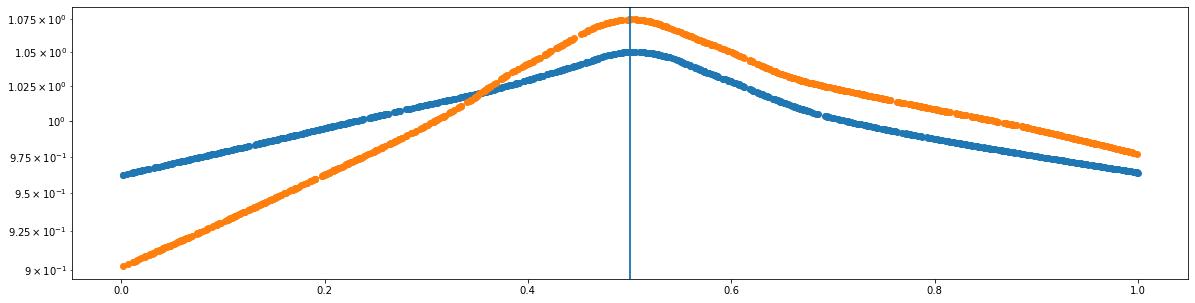

In [22]:
plt.figure(figsize=(20, 5))
for i in range(2):
    z, p = sw2.posterior(i, version = -1)
    plt.axvline(z0[i])
    plt.scatter(z, p)
plt.gca().set_yscale('log')

In [25]:
sw2.init_netNd([[0, 1]])

In [26]:
sw2.trainNd(max_epochs = 1)

Start training
LR iteration 0
Total epochs: 1
Validation losses: [1.4574742168188095]
LR iteration 1
Total epochs: 1
Validation losses: [1.3588384953327477]
LR iteration 2
Total epochs: 1
Validation losses: [1.357977259438485]


In [27]:
sw2.eval_postNd()

(0.0, 1.0)

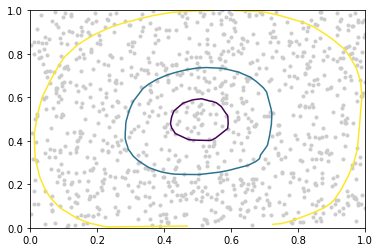

In [28]:
zgrid, lnLgrid = sw2.posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], (-lnLgrid+max_lnL)*2, levels = [1, 4, 9])
plt.xlim([0, 1])
plt.ylim([0, 1])